In [70]:
import pandas as pd
import matplotlib.pyplot as plt
import datetime as dt
import warnings

# Suppress warning messages
warnings.filterwarnings('ignore')
pd.options.display.max_columns = 200
pd.options.display.max_rows = 2000
# display all rows & columns
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [71]:
tmdls = pd.read_csv('all_actions.csv', parse_dates=['TMDLDate'], date_parser=lambda t: pd.to_datetime(t, errors='coerce')).drop('Unnamed: 0', axis=1).rename(columns={'assessmentUnitIdentifier':'AUID'})
huc_npdes_permit_links = pd.read_csv('huc_npdes_permit_links.csv').rename(columns={'attributes.WBD_HUC12': 'HUC-12'})
huc_AUID_links = pd.read_csv('huc_AUID_links.csv').rename(columns={'attributes.assessmentunitidentifier':'AUID', 'attributes.huc12': 'HUC-12'})
permit_dates = pd.read_csv('permit_dates.csv', parse_dates=['effective_date','issue_date','original_effective_date','original_issue_date','expiration_date','retirement_date','termination_date'], date_parser=lambda t: pd.to_datetime(t, errors='coerce'))
# Drop permits without an issue date
permit_dates.dropna(subset='issue_date', inplace=True)

In [72]:
len(tmdls.drop_duplicates('actionIdentifier'))

20009

In [73]:
tmdls_merged = tmdls.drop_duplicates().merge(huc_AUID_links, on='AUID', how='inner').merge(huc_npdes_permit_links, on='HUC-12', how='inner')

In [74]:
len(tmdls_merged.drop_duplicates('npdes_permit_id'))

260319

In [75]:
len(tmdls_merged.drop_duplicates('HUC-12'))

9166

In [76]:
len(tmdls_merged.drop_duplicates('AUID'))

69540

In [77]:
len(tmdls_merged.drop_duplicates('actionIdentifier'))

6626

In [78]:
tmdls_merged = tmdls_merged.merge(permit_dates, on='npdes_permit_id', how='inner')
del permit_dates
del tmdls
del huc_AUID_links
del huc_npdes_permit_links

In [79]:
tmdls_merged['incumbent'] = (tmdls_merged['issue_date'] <= tmdls_merged['TMDLDate'])

# Drop permits which expired/retired/terminated before the TMDL
tmdls_merged = tmdls_merged[~(tmdls_merged['expiration_date'] <= tmdls_merged['TMDLDate']) &
                            ~(tmdls_merged['retirement_date'] <= tmdls_merged['TMDLDate']) &
                            ~(tmdls_merged['termination_date'] <= tmdls_merged['TMDLDate'])]

In [80]:
len(tmdls_merged.drop_duplicates('npdes_permit_id'))

205832

In [81]:
tmdls_merged.drop_duplicates('npdes_permit_id')['incumbent'].value_counts()

False    152744
True      53088
Name: incumbent, dtype: int64

In [82]:
tmdls_merged_AL = tmdls_merged[tmdls_merged['permit_state']=='AL']
del tmdls_merged

In [83]:
tmdls_merged_AL.drop_duplicates('npdes_permit_id')['incumbent'].value_counts()

False    3434
True      839
Name: incumbent, dtype: int64

In [84]:
tmdls_merged_AL['pollutantName'].value_counts()

ESCHERICHIA COLI (E. COLI)          6138
TOTAL SUSPENDED SOLIDS (TSS)        2863
PHOSPHORUS, TOTAL                   2475
FECAL COLIFORM                      1327
CARBONACEOUS BOD                    1190
NITROGENOUS BOD                     1190
MERCURY                             1043
MERCURY IN FISH TISSUE               495
ENTEROCOCCUS BACTERIA                227
PH                                   185
POLYCHLORINATED BIPHENYLS (PCBS)     110
ALUMINUM                              68
DIOXINS                               64
LEAD                                  42
SEDIMENT                              18
SILTATION                             12
NITROGEN, TOTAL                        4
CHLOROPHYLL-A                          2
Name: pollutantName, dtype: int64

In [100]:
# Read in DMR data for limit comparisons
AL_dmrs = pd.read_csv('~/Documents/DMR Work/DMR Python Projects/dmr-permit-limit-changes/dmr_data/AL_dmrs.csv')

In [86]:
# Extract only limits from DMR data
AL_limits = AL_dmrs.drop_duplicates(subset=['npdes_permit_id', 'perm_feature_nmbr', 'parameter_desc', 'limit_value_type_code', 'limit_value_nmbr', 'statistical_base_code', 'limit_begin_date'])
del AL_dmrs
len(AL_limits)

460407

In [87]:
len(AL_limits[AL_limits['parameter_desc']=='pH'])

68653

In [88]:
len(AL_limits[AL_limits['parameter_desc']=='Polychlorinated biphenyls [PCBs]'])

28

In [89]:
len(AL_limits[AL_limits['parameter_desc'].apply(lambda x: x in ['Phosphorus, Total As P', 'Phosphorus, total [as P]', 'Phosphorous, total elemental', 'Phosphorous, total organic [as P]', 'Phosphorous, total recoverable'])])

16185

In [90]:
len(AL_limits[AL_limits['parameter_desc']=='E. coli'])

4678

In [91]:
len(AL_limits[AL_limits['parameter_desc']=='Solids, total suspended'])

53062

In [92]:
len(AL_limits[AL_limits['parameter_desc'].apply(lambda x: x in ['Mercury [Hg], in barite, dry weight','Mercury, dissolved [as Hg]', 'Mercury, total [as Hg]','Mercury, total [low level]', 'Mercury, total recoverable'])])

3923

Let's first look at E. coli:

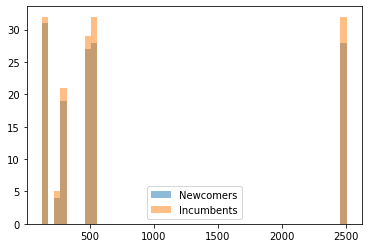

In [93]:
to_plot = AL_limits[AL_limits['parameter_desc']=='E. coli']
to_merge = tmdls_merged_AL[tmdls_merged_AL['pollutantName']=='ESCHERICHIA COLI (E. COLI)']
to_plot = to_plot.merge(to_merge[['npdes_permit_id', 'issue_date', 'incumbent', 'actionIdentifier', 'TMDLDate', 'AUID', 'HUC-12']]).drop(['series_id', 'monitoring_period_end_date', 'monitoring_period_quarter_start', 'monitoring_period_quarter_end', 'monitoring_period_end_month', 'nmbr_of_submission', 'nmbr_of_report', 'dmr_unit_desc', 'dmr_unit_code', 'dmr_value_standard_units', 'value_received_date', 'value_received_month', 'value_received_quarter_start', 'value_received_quarter_end'], axis=1)
plt.figure()
plt.hist(to_plot[to_plot['incumbent']==False].drop_duplicates(subset=['npdes_permit_id', 'perm_feature_nmbr', 'limit_value_nmbr'])['limit_value_nmbr'], label='Newcomers', bins=50, alpha=0.5);
plt.hist(to_plot[to_plot['incumbent']==True].drop_duplicates(subset=['npdes_permit_id', 'perm_feature_nmbr', 'limit_value_nmbr'])['limit_value_nmbr'], label='Incumbents', bins=50, alpha=0.5);
plt.legend()

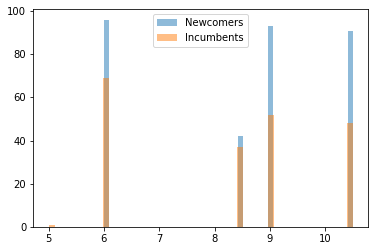

In [94]:
to_plot = AL_limits[AL_limits['parameter_desc']=='pH']
to_merge = tmdls_merged_AL[tmdls_merged_AL['pollutantName']=='PH']
to_plot = to_plot.merge(to_merge[['npdes_permit_id', 'issue_date', 'incumbent', 'actionIdentifier', 'TMDLDate', 'AUID', 'HUC-12']]).drop(['series_id', 'monitoring_period_end_date', 'monitoring_period_quarter_start', 'monitoring_period_quarter_end', 'monitoring_period_end_month', 'nmbr_of_submission', 'nmbr_of_report', 'dmr_unit_desc', 'dmr_unit_code', 'dmr_value_standard_units', 'value_received_date', 'value_received_month', 'value_received_quarter_start', 'value_received_quarter_end'], axis=1)
plt.figure()
plt.hist(to_plot[to_plot['incumbent']==False].drop_duplicates(subset=['npdes_permit_id', 'perm_feature_nmbr', 'limit_value_nmbr'])['limit_value_nmbr'], label='Newcomers', bins=50, alpha=0.5);
plt.hist(to_plot[to_plot['incumbent']==True].drop_duplicates(subset=['npdes_permit_id', 'perm_feature_nmbr', 'limit_value_nmbr'])['limit_value_nmbr'], label='Incumbents', bins=50, alpha=0.5);
plt.legend()

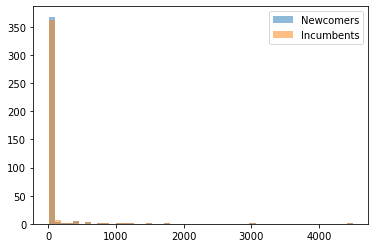

In [97]:
to_plot = AL_limits[AL_limits['parameter_desc']=='Solids, total suspended']
to_merge = tmdls_merged_AL[tmdls_merged_AL['pollutantName']=='TOTAL SUSPENDED SOLIDS (TSS)']
to_plot = to_plot.merge(to_merge[['npdes_permit_id', 'issue_date', 'incumbent', 'actionIdentifier', 'TMDLDate', 'AUID', 'HUC-12']]).drop(['series_id', 'monitoring_period_end_date', 'monitoring_period_quarter_start', 'monitoring_period_quarter_end', 'monitoring_period_end_month', 'nmbr_of_submission', 'nmbr_of_report', 'dmr_unit_desc', 'dmr_unit_code', 'dmr_value_standard_units', 'value_received_date', 'value_received_month', 'value_received_quarter_start', 'value_received_quarter_end'], axis=1)
plt.figure()
plt.hist(to_plot[to_plot['incumbent']==False].drop_duplicates(subset=['npdes_permit_id', 'perm_feature_nmbr', 'limit_value_nmbr'])['limit_value_nmbr'], label='Newcomers', bins=50, alpha=0.5);
plt.hist(to_plot[to_plot['incumbent']==True].drop_duplicates(subset=['npdes_permit_id', 'perm_feature_nmbr', 'limit_value_nmbr'])['limit_value_nmbr'], label='Incumbents', bins=50, alpha=0.5);
plt.legend()

In [98]:
to_plot.drop_duplicates(subset=['npdes_permit_id', 'perm_feature_nmbr', 'limit_value_nmbr'])

,npdes_permit_id,perm_feature_nmbr,parameter_desc,limit_id,limit_value_id,limit_begin_date,limit_end_date,limit_value_type_code,limit_value_nmbr,limit_value_standard_units,statistical_base_code,statistical_base_type_code,standard_unit_desc,value_type_code,issue_date,incumbent,actionIdentifier,TMDLDate,AUID,HUC-12
0,AL0022934,001,"Solids, total suspended",1600015926,1600079631,2001-02-01 00:00:00,2006-01-31 00:00:00,Q2,NaN,NaN,WA,AVG,kg/d,Q2,2012-11-28,True,54160,2013-08-14,AL03150202-0101-102,3.150202e+10
96,AL0022934,001,"Solids, total suspended",1600015924,1600079623,2001-02-01 00:00:00,2006-01-31 00:00:00,C2,30.00,30.000000,MK,AVG,mg/L,C2,2012-11-28,True,54160,2013-08-14,AL03150202-0101-102,3.150202e+10
128,AL0022934,001,"Solids, total suspended",1600015924,1600079621,2001-02-01 00:00:00,2006-01-31 00:00:00,Q2,1501.00,681.454000,WA,AVG,kg/d,Q2,2012-11-28,True,54160,2013-08-14,AL03150202-0101-102,3.150202e+10
160,AL0022934,001,"Solids, total suspended",1600015924,1600079624,2001-02-01 00:00:00,2006-01-31 00:00:00,C3,45.00,45.000000,WA,AVG,mg/L,C3,2012-11-28,True,54160,2013-08-14,AL03150202-0101-102,3.150202e+10
224,AL0022934,001,"Solids, total suspended",1600015924,1600079620,2001-02-01 00:00:00,2006-01-31 00:00:00,Q1,1000.00,454.000000,MK,AVG,kg/d,Q1,2012-11-28,True,54160,2013-08-14,AL03150202-0101-102,3.150202e+10
256,AL0022934,003,"Solids, total suspended",1600016057,1600080289,2001-02-01 00:00:00,2006-01-31 00:00:00,C3,NaN,NaN,DD,MAX,mg/L,C3,2012-11-28,True,54160,2013-08-14,AL03150202-0101-102,3.150202e+10
288,AL0022934,002,"Solids, total suspended",1600016049,1600080249,2001-02-01 00:00:00,2006-01-31 00:00:00,C3,NaN,NaN,DD,MAX,mg/L,C3,2012-11-28,True,54160,2013-08-14,AL03150202-0101-102,3.150202e+10
384,AL0022934,005,"Solids, total suspended",1600016073,1600080366,2001-02-01 00:00:00,2006-01-31 00:00:00,Q2,NaN,NaN,DD,MAX,kg/d,Q2,2012-11-28,True,54160,2013-08-14,AL03150202-0101-102,3.150202e+10
448,AL0022934,004,"Solids, total suspended",1600016065,1600080329,2001-02-01 00:00:00,2006-01-31 00:00:00,C3,NaN,NaN,DD,MAX,mg/L,C3,2012-11-28,True,54160,2013-08-14,AL03150202-0101-102,3.150202e+10
1152,AL0022934,007,"Solids, total suspended",3603662044,3606242578,2019-01-01 00:00:00,2023-05-31 00:00:00,C3,NaN,NaN,DD,MAX,mg/L,C3,2012-11-28,True,54160,2013-08-14,AL03150202-0101-102,3.150202e+10


In [110]:
tmdls_merged_AL[['npdes_permit_id', 'issue_date', 'TMDLDate', 'incumbent']].head(500)

,npdes_permit_id,issue_date,TMDLDate,incumbent
0,ALR107777,2011-07-27,2010-09-21,False
1,ALR10AAY0,2013-08-15,2010-09-21,False
2,ALR10AM01,2014-06-11,2010-09-21,False
3,ALR10AA85,2016-04-05,2010-09-21,False
4,ALR10AA85,2021-04-01,2010-09-21,False
5,ALR10AA85,2013-06-12,2010-09-21,False
6,ALR10AN53,2014-09-04,2010-09-21,False
7,ALR10BBY8,2017-04-17,2010-09-21,False
8,ALR10BDTA,2018-08-03,2010-09-21,False
9,ALR10BCC1,2017-06-20,2010-09-21,False


In [103]:
AL_dmrs[AL_dmrs['limit_value_id']==1600079623]

,npdes_permit_id,series_id,perm_feature_nmbr,monitoring_period_end_date,monitoring_period_quarter_start,monitoring_period_quarter_end,monitoring_period_end_month,nmbr_of_submission,nmbr_of_report,parameter_desc,dmr_unit_desc,dmr_unit_code,dmr_value_standard_units,limit_id,limit_value_id,limit_begin_date,limit_end_date,limit_value_type_code,limit_value_nmbr,limit_value_standard_units,statistical_base_code,statistical_base_type_code,standard_unit_desc,value_received_date,value_received_month,value_received_quarter_start,value_received_quarter_end,value_type_code
66657,AL0022934,AL0022934_00530_1600002470_1600003316_16000159...,001,2008-10-31 00:00:00,2008-10-01 00:00:00,2008-12-31 00:00:00,2008-10-01 00:00:00,1,1,"Solids, total suspended",NaN,NaN,1.1,1600015924,1600079623,2001-02-01 00:00:00,2006-01-31 00:00:00,C2,30.0,30.0,MK,AVG,mg/L,2008-12-04 00:00:00,2008-12-01 00:00:00,2008-10-01 00:00:00,2008-12-31 00:00:00,C2
66693,AL0022934,AL0022934_00530_1600002470_1600003316_16000159...,001,2008-11-30 00:00:00,2008-10-01 00:00:00,2008-12-31 00:00:00,2008-11-01 00:00:00,1,1,"Solids, total suspended",NaN,NaN,2.8,1600015924,1600079623,2001-02-01 00:00:00,2006-01-31 00:00:00,C2,30.0,30.0,MK,AVG,mg/L,2009-01-08 00:00:00,2009-01-01 00:00:00,2009-01-01 00:00:00,2009-03-31 00:00:00,C2
66878,AL0022934,AL0022934_00530_1600002470_1600003316_16000159...,001,2009-05-31 00:00:00,2009-04-01 00:00:00,2009-06-30 00:00:00,2009-05-01 00:00:00,1,1,"Solids, total suspended",mg/L,19,1.7,1600015924,1600079623,2001-02-01 00:00:00,2006-01-31 00:00:00,C2,30.0,30.0,MK,AVG,mg/L,2009-07-01 00:00:00,2009-07-01 00:00:00,2009-07-01 00:00:00,2009-09-30 00:00:00,C2
66917,AL0022934,AL0022934_00530_1600002470_1600003316_16000159...,001,2009-06-30 00:00:00,2009-04-01 00:00:00,2009-06-30 00:00:00,2009-06-01 00:00:00,1,1,"Solids, total suspended",mg/L,19,1.5,1600015924,1600079623,2001-02-01 00:00:00,2006-01-31 00:00:00,C2,30.0,30.0,MK,AVG,mg/L,2009-07-31 00:00:00,2009-07-01 00:00:00,2009-07-01 00:00:00,2009-09-30 00:00:00,C2
66958,AL0022934,AL0022934_00530_1600002470_1600003316_16000159...,001,2009-07-31 00:00:00,2009-07-01 00:00:00,2009-09-30 00:00:00,2009-07-01 00:00:00,1,1,"Solids, total suspended",mg/L,19,2.5,1600015924,1600079623,2001-02-01 00:00:00,2006-01-31 00:00:00,C2,30.0,30.0,MK,AVG,mg/L,2009-09-08 00:00:00,2009-09-01 00:00:00,2009-07-01 00:00:00,2009-09-30 00:00:00,C2
66979,AL0022934,AL0022934_00530_1600002470_1600003316_16000159...,001,2009-08-31 00:00:00,2009-07-01 00:00:00,2009-09-30 00:00:00,2009-08-01 00:00:00,1,1,"Solids, total suspended",mg/L,19,2.3,1600015924,1600079623,2001-02-01 00:00:00,2006-01-31 00:00:00,C2,30.0,30.0,MK,AVG,mg/L,2009-09-28 00:00:00,2009-09-01 00:00:00,2009-07-01 00:00:00,2009-09-30 00:00:00,C2
67034,AL0022934,AL0022934_00530_1600002470_1600003316_16000159...,001,2009-09-30 00:00:00,2009-07-01 00:00:00,2009-09-30 00:00:00,2009-09-01 00:00:00,1,1,"Solids, total suspended",mg/L,19,2.2,1600015924,1600079623,2001-02-01 00:00:00,2006-01-31 00:00:00,C2,30.0,30.0,MK,AVG,mg/L,2009-11-05 00:00:00,2009-11-01 00:00:00,2009-10-01 00:00:00,2009-12-31 00:00:00,C2
639644,AL0022934,AL0022934_00530_1600002470_1600003316_16000159...,001,2009-10-31 00:00:00,2009-10-01 00:00:00,2009-12-31 00:00:00,2009-10-01 00:00:00,1,1,"Solids, total suspended",mg/L,19,1.4,1600015924,1600079623,2001-02-01 00:00:00,2006-01-31 00:00:00,C2,30.0,30.0,MK,AVG,mg/L,2009-12-09 00:00:00,2009-12-01 00:00:00,2009-10-01 00:00:00,2009-12-31 00:00:00,C2
639692,AL0022934,AL0022934_00530_1600002470_1600003316_16000159...,001,2009-11-30 00:00:00,2009-10-01 00:00:00,2009-12-31 00:00:00,2009-11-01 00:00:00,1,1,"Solids, total suspended",mg/L,19,1.1,1600015924,1600079623,2001-02-01 00:00:00,2006-01-31 00:00:00,C2,30.0,30.0,MK,AVG,mg/L,2009-12-23 00:00:00,2009-12-01 00:00:00,2009-10-01 00:00:00,2009-12-31 00:00:00,C2
639939,AL0022934,AL0022934_00530_1600002470_1600003316_16000159...,001,2010-05-31 00:00:00,2010-04-01 00:00:00,2010-06-30 00:00:00,2010-05-01 00:00:00,1,1,"Solids, total sus

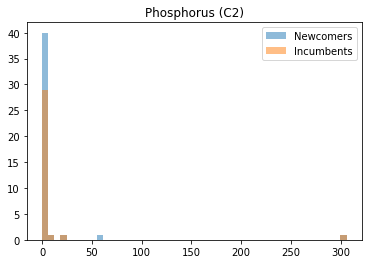

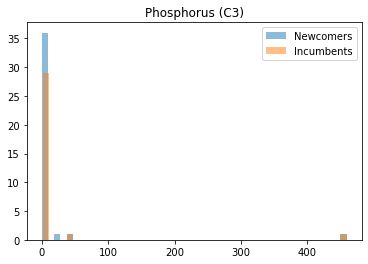

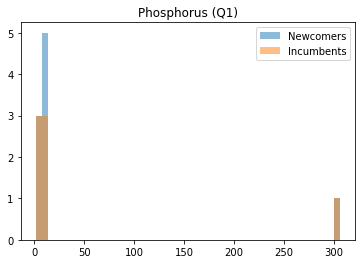

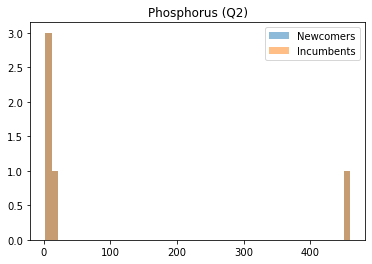

In [95]:
to_plot = AL_limits[AL_limits['parameter_desc'].apply(lambda x: x in ['Phosphorus, Total As P', 'Phosphorus, total [as P]', 'Phosphorous, total elemental', 'Phosphorous, total organic [as P]', 'Phosphorous, total recoverable'])]
to_merge = tmdls_merged_AL[tmdls_merged_AL['pollutantName']=='PHOSPHORUS, TOTAL']
to_plot = to_plot.merge(to_merge[['npdes_permit_id', 'issue_date', 'incumbent', 'actionIdentifier', 'TMDLDate', 'AUID', 'HUC-12']]).drop(['series_id', 'monitoring_period_end_date', 'monitoring_period_quarter_start', 'monitoring_period_quarter_end', 'monitoring_period_end_month', 'nmbr_of_submission', 'nmbr_of_report', 'dmr_unit_desc', 'dmr_unit_code', 'dmr_value_standard_units', 'value_received_date', 'value_received_month', 'value_received_quarter_start', 'value_received_quarter_end'], axis=1)
for value_type in to_plot['limit_value_type_code'].unique():
    plt.figure()
    plt.hist(to_plot[(to_plot['incumbent']==False) & (to_plot['limit_value_type_code']==value_type)].drop_duplicates(subset=['npdes_permit_id', 'perm_feature_nmbr', 'limit_value_nmbr'])['limit_value_nmbr'], label='Newcomers', bins=50, alpha=0.5);
    plt.hist(to_plot[(to_plot['incumbent']==True) & (to_plot['limit_value_type_code']==value_type)].drop_duplicates(subset=['npdes_permit_id', 'perm_feature_nmbr', 'limit_value_nmbr'])['limit_value_nmbr'], label='Incumbents', bins=50, alpha=0.5);
    plt.legend()
    plt.title('Phosphorus (' + value_type + ')')

In [96]:
to_plot.drop_duplicates(subset=['npdes_permit_id', 'perm_feature_nmbr', 'limit_value_nmbr']).sort_values('issue_date')

,npdes_permit_id,perm_feature_nmbr,parameter_desc,limit_id,limit_value_id,limit_begin_date,limit_end_date,limit_value_type_code,limit_value_nmbr,limit_value_standard_units,statistical_base_code,statistical_base_type_code,standard_unit_desc,value_type_code,issue_date,incumbent,actionIdentifier,TMDLDate,AUID,HUC-12
6571,ALG110113,012,"Phosphorus, total [as P]",1600087550,1600437754,2007-09-01 00:00:00,2012-08-31 00:00:00,C3,1.000,1.00000,DD,MAX,mg/L,C3,2002-09-01,True,30895,2006-10-26,AL03150202-0104-102,3.150202e+10
6583,ALG110113,12,"Phosphorus, total [as P]",1600087550,1600437754,2007-09-01 00:00:00,2012-08-31 00:00:00,C3,1.000,1.00000,DD,MAX,mg/L,C3,2002-09-01,True,30895,2006-10-26,AL03150202-0104-102,3.150202e+10
6811,ALG120264,2,"Phosphorus, total [as P]",1600106214,1600531074,2007-10-01 00:00:00,2012-09-30 00:00:00,C3,NaN,NaN,DD,MAX,mg/L,C3,2002-10-01,True,30895,2006-10-26,AL03150202-0101-102,3.150202e+10
6835,ALG120264,002,"Phosphorus, total [as P]",3000338706,3000518192,2013-01-01 00:00:00,2017-09-30 00:00:00,C3,NaN,NaN,DD,MAX,mg/L,C3,2002-10-01,True,30895,2006-10-26,AL03150202-0101-102,3.150202e+10
2699,AL0057657,001,"Phosphorus, total [as P]",3400511975,3400769863,2015-01-01 00:00:00,2018-01-31 00:00:00,C2,1.000,1.00000,MK,AVG,mg/L,C2,2004-01-21,True,11567,2008-10-28,AL03150106-0309-101,3.150106e+10
2639,AL0057657,001,"Phosphorus, total [as P]",1600037367,1600186838,2004-02-01 00:00:00,2009-01-31 00:00:00,C2,NaN,NaN,MK,AVG,mg/L,C2,2004-01-21,True,11567,2008-10-28,AL03150106-0309-101,3.150106e+10
2687,AL0057657,001,"Phosphorus, total [as P]",3400511974,3400769859,2013-02-01 00:00:00,2014-12-31 00:00:00,C2,1.700,1.70000,MK,AVG,mg/L,C2,2004-01-21,True,11567,2008-10-28,AL03150106-0309-101,3.150106e+10
7574,ALG140819,7,"Phosphorus, total [as P]",1600134643,1600673219,2007-10-01 00:00:00,2012-09-30 00:00:00,C3,1.000,1.00000,DD,MAX,mg/L,C3,2004-10-01,True,30895,2006-10-26,AL03150202-0104-102,3.150202e+10
7943,AL0056685,001,"Phosphorus, total [as P]",2600039888,2600060657,2011-03-01 00:00:00,2013-02-28 00:00:00,C2,2.700,2.70000,MK,AVG,mg/L,C2,2005-01-10,True,30895,2006-10-26,AL03150202-0104-102,3.150202e+10
7958,AL0056685,001,"Phosphorus, total [as P]",2600039894,2600060678,2013-02-01 00:00:00,2013-02-28 00:00:00,C2,0.300,0.30000,MK,AVG,mg/L,C2,2005-01-10,True,30895,2006-10-26,AL03150202-0104-102,3.150202e+10
